In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
import matplotlib.pyplot as plt
import pandas as pd

## Let's select some of the parameters

Here we are fixing some parameters that we will use later. 

In [4]:
# Select some parameters
datasize = 300 #number of data to be generated
tr_vl_splitting = 0.75 #training/validation splitting
epochs = 600 #number of epochs  
data_test = 100 #number of data to be used as test at the end
err_prob = 0.02 #probability of an error in the classification 
dev_std_exp = 0.3 #dev_std of the exp data
mom_thre = 20.0 #momentum threshold for the classification

### This is the classification algorithm that we want to discover 

This function is a fake law of nature that, according to the momentum of two particles and the total charge, return a type of process (that are denoted with either ``0`` or ``1``). On of the parameter of the law is the momentum threshold on the sum which is given by `mom_thre`. There is also an error probability given by ``err_prob`` that simulates noise.

In [5]:
def what_process(momentum1, momentum2, charge, err_prob):
    res = 0
    if ((momentum1 + momentum2) > mom_thre) and (momentum1 < momentum2):
        if charge == 1:
            res=0
        else:
            res=1
    elif ((momentum1 + momentum2) > mom_thre) and (momentum1 > momentum2):
        if charge == 1:
            res=1
        else:
            res=0
    elif (momentum1 + momentum2) < mom_thre:
        if charge == 0:
            res = 1
        else:
            res = 0
    if np.random.rand(1)[0] < err_prob:
        if res==0:
            res = 1
        else:
            res = 0
    return res    

Let's now generate the fake datasets for our classification example. Note that we are already splitting in validation and training datasets. Moreover we are also creating a *test* datasets that the fit will never see and that will be used as final valutation for our algorithm. Note that the test datasets have been generated with an error probability equal to 0 in order to verify if the neural network is able to extract the real law regardless of the error probability.  

In [6]:
data_tr_size = int(datasize*tr_vl_splitting) #how many points in training
data_val_size = datasize - data_tr_size #how many points in validation
x_exp_data_tr = [] #x_data measured by experimentalist for training
x_exp_data_val = [] #x_data measured by experimentalist for validation
y_exp_data_tr = [] #y_data measured by experimentalist for training
y_exp_data_val = [] #y_data measured by experimentalist for validation
x_exp_data_test = [] #x_data measured by experimentalist for test
y_exp_data_test = [] #y_data measured by experimentalist for test
# Generating all the data:
# The x are list of [momentum1, momentum2, charge]
# The y are either 0 or 1
for _ in range(data_tr_size):
    mom1 = np.random.normal(loc = 10*np.random.rand(1)[0], scale = dev_std_exp*10) #GeV
    mom2 = np.random.normal(loc = 20*np.random.rand(1)[0], scale = dev_std_exp*20) #GeV
    charge = np.random.randint(-1,2)
    x_exp_data_tr.append(np.array([mom1, mom2, charge]))
    y_exp_data_tr.append(what_process(mom1, mom2, charge, err_prob))
for _ in range(data_val_size):
    mom1 = np.random.normal(loc = 10*np.random.rand(1)[0], scale = dev_std_exp*10) #GeV
    mom2 = np.random.normal(loc = 20*np.random.rand(1)[0], scale = dev_std_exp*20) #GeV
    charge = np.random.randint(-1,2)
    x_exp_data_val.append(np.array([mom1, mom2, charge]))
    y_exp_data_val.append(what_process(mom1, mom2, charge, err_prob))
for _ in range(data_test):
    mom1 = np.random.normal(loc = 10*np.random.rand(1)[0], scale = dev_std_exp*10) #GeV
    mom2 = np.random.normal(loc = 20*np.random.rand(1)[0], scale = dev_std_exp*20) #GeV
    charge = np.random.randint(-1,2)
    x_exp_data_test.append(np.array([mom1, mom2, charge]))
    #The test data are generated without error probability
    y_exp_data_test.append(what_process(mom1, mom2, charge, err_prob=0))

Let's visualize the data in a 3D plot

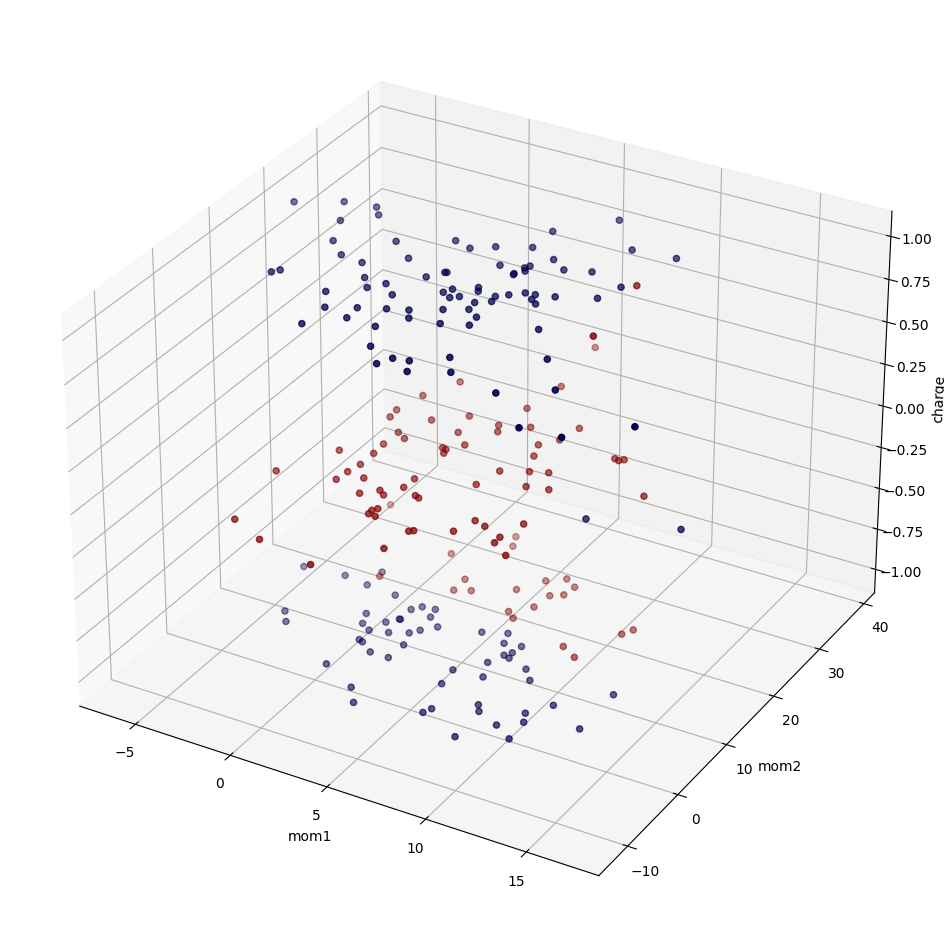

In [7]:

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.set_xlabel("mom1")
ax.set_ylabel("mom2")
ax.set_zlabel("charge")
ax.scatter3D(np.array(x_exp_data_tr).transpose()[0], np.array(x_exp_data_tr).transpose()[1], np.array(x_exp_data_tr).transpose()[2], c=y_exp_data_tr, cmap='seismic')

%matplotlib inline



## Let's now build the model 

Let's now construct our classification model. We are going to build a two layer model: the first with 60 units and with the ``relu`` activation function, the second with 1 unit and with the `sigmoid` activation function.

As loss we are going to use the ``BinaryCrossentropy`` which is best suited for binary classification problems as our own and finally as optimizer we are going to use the ``Adam`` optimizer.

The following is the summary of the model.

In [9]:
model = keras.Sequential([ layers.Dense(60,input_dim = 3, name="layer1",activation=tf.nn.relu),layers.Dense(1,name="layer2",activation=tf.nn.sigmoid)])
loss_scc = keras.losses.BinaryCrossentropy() #loss function
opt_adam = keras.optimizers.Adam() #optimizer
model.compile(loss=loss_scc, optimizer = opt_adam, metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 60)                240       
                                                                 
 layer2 (Dense)              (None, 1)                 61        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None


### Model training

Let's now train our model on our dataset with the function `fit`.

In [10]:
history = model.fit(x = np.array(x_exp_data_tr), y = np.array(y_exp_data_tr), batch_size = 5, epochs = epochs, validation_data = (np.array(x_exp_data_val),np.array(y_exp_data_val)))


Epoch 1/600


2023-06-22 15:52:49.316671: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


45/45 [==============================] - 0s 2ms/step - loss: 0.7119 - accuracy: 0.5822 - val_loss: 0.7147 - val_accuracy: 0.5067
Epoch 2/600
45/45 [==============================] - 0s 673us/step - loss: 0.6686 - accuracy: 0.5911 - val_loss: 0.6706 - val_accuracy: 0.5067
Epoch 3/600
45/45 [==============================] - 0s 617us/step - loss: 0.6517 - accuracy: 0.5822 - val_loss: 0.6552 - val_accuracy: 0.5600
Epoch 4/600
45/45 [==============================] - 0s 621us/step - loss: 0.6344 - accuracy: 0.5911 - val_loss: 0.6521 - val_accuracy: 0.6267
Epoch 5/600
45/45 [==============================] - 0s 654us/step - loss: 0.6175 - accuracy: 0.6311 - val_loss: 0.6377 - val_accuracy: 0.5600
Epoch 6/600
45/45 [==============================] - 0s 626us/step - loss: 0.6024 - accuracy: 0.6444 - val_loss: 0.6649 - val_accuracy: 0.6133
Epoch 7/600
45/45 [==============================] - 0s 605us/step - loss: 0.5853 - accuracy: 0.6933 - val_loss: 0.6436 - val_accuracy: 0.5200
Epoch 8/600
4

45/45 [==============================] - 0s 620us/step - loss: 0.1459 - accuracy: 0.9689 - val_loss: 0.2004 - val_accuracy: 0.9333
Epoch 59/600
45/45 [==============================] - 0s 590us/step - loss: 0.1464 - accuracy: 0.9689 - val_loss: 0.2099 - val_accuracy: 0.9333
Epoch 60/600
45/45 [==============================] - 0s 605us/step - loss: 0.1403 - accuracy: 0.9733 - val_loss: 0.1956 - val_accuracy: 0.9333
Epoch 61/600
45/45 [==============================] - 0s 580us/step - loss: 0.1420 - accuracy: 0.9689 - val_loss: 0.1943 - val_accuracy: 0.9200
Epoch 62/600
45/45 [==============================] - 0s 577us/step - loss: 0.1380 - accuracy: 0.9733 - val_loss: 0.1950 - val_accuracy: 0.9333
Epoch 63/600
45/45 [==============================] - 0s 580us/step - loss: 0.1328 - accuracy: 0.9689 - val_loss: 0.2014 - val_accuracy: 0.9333
Epoch 64/600
45/45 [==============================] - 0s 601us/step - loss: 0.1397 - accuracy: 0.9689 - val_loss: 0.1987 - val_accuracy: 0.9333
Epoch

Epoch 115/600
45/45 [==============================] - 0s 586us/step - loss: 0.0866 - accuracy: 0.9778 - val_loss: 0.2104 - val_accuracy: 0.9200
Epoch 116/600
45/45 [==============================] - 0s 606us/step - loss: 0.0928 - accuracy: 0.9689 - val_loss: 0.2103 - val_accuracy: 0.9200
Epoch 117/600
45/45 [==============================] - 0s 607us/step - loss: 0.0900 - accuracy: 0.9733 - val_loss: 0.2064 - val_accuracy: 0.9067
Epoch 118/600
45/45 [==============================] - 0s 578us/step - loss: 0.0836 - accuracy: 0.9778 - val_loss: 0.2223 - val_accuracy: 0.9200
Epoch 119/600
45/45 [==============================] - 0s 596us/step - loss: 0.0832 - accuracy: 0.9733 - val_loss: 0.2060 - val_accuracy: 0.9200
Epoch 120/600
45/45 [==============================] - 0s 589us/step - loss: 0.0867 - accuracy: 0.9778 - val_loss: 0.2112 - val_accuracy: 0.9200
Epoch 121/600
45/45 [==============================] - 0s 580us/step - loss: 0.0840 - accuracy: 0.9778 - val_loss: 0.2092 - val_ac

45/45 [==============================] - 0s 593us/step - loss: 0.0603 - accuracy: 0.9822 - val_loss: 0.2385 - val_accuracy: 0.9200
Epoch 172/600
45/45 [==============================] - 0s 607us/step - loss: 0.0564 - accuracy: 0.9778 - val_loss: 0.2461 - val_accuracy: 0.9067
Epoch 173/600
45/45 [==============================] - 0s 577us/step - loss: 0.0571 - accuracy: 0.9778 - val_loss: 0.2456 - val_accuracy: 0.9200
Epoch 174/600
45/45 [==============================] - 0s 595us/step - loss: 0.0597 - accuracy: 0.9822 - val_loss: 0.2606 - val_accuracy: 0.9200
Epoch 175/600
45/45 [==============================] - 0s 586us/step - loss: 0.0638 - accuracy: 0.9733 - val_loss: 0.2485 - val_accuracy: 0.9200
Epoch 176/600
45/45 [==============================] - 0s 575us/step - loss: 0.0607 - accuracy: 0.9733 - val_loss: 0.2529 - val_accuracy: 0.9200
Epoch 177/600
45/45 [==============================] - 0s 565us/step - loss: 0.0573 - accuracy: 0.9689 - val_loss: 0.2436 - val_accuracy: 0.9200

45/45 [==============================] - 0s 599us/step - loss: 0.0483 - accuracy: 0.9778 - val_loss: 0.2882 - val_accuracy: 0.9200
Epoch 228/600
45/45 [==============================] - 0s 584us/step - loss: 0.0479 - accuracy: 0.9822 - val_loss: 0.2814 - val_accuracy: 0.9200
Epoch 229/600
45/45 [==============================] - 0s 586us/step - loss: 0.0436 - accuracy: 0.9778 - val_loss: 0.2872 - val_accuracy: 0.9200
Epoch 230/600
45/45 [==============================] - 0s 575us/step - loss: 0.0461 - accuracy: 0.9867 - val_loss: 0.2949 - val_accuracy: 0.9200
Epoch 231/600
45/45 [==============================] - 0s 582us/step - loss: 0.0439 - accuracy: 0.9822 - val_loss: 0.2883 - val_accuracy: 0.9200
Epoch 232/600
45/45 [==============================] - 0s 592us/step - loss: 0.0441 - accuracy: 0.9867 - val_loss: 0.2811 - val_accuracy: 0.9067
Epoch 233/600
45/45 [==============================] - 0s 601us/step - loss: 0.0479 - accuracy: 0.9867 - val_loss: 0.2916 - val_accuracy: 0.9200

45/45 [==============================] - 0s 572us/step - loss: 0.0371 - accuracy: 0.9822 - val_loss: 0.2912 - val_accuracy: 0.9067
Epoch 284/600
45/45 [==============================] - 0s 603us/step - loss: 0.0399 - accuracy: 0.9911 - val_loss: 0.2918 - val_accuracy: 0.9067
Epoch 285/600
45/45 [==============================] - 0s 583us/step - loss: 0.0378 - accuracy: 0.9867 - val_loss: 0.3054 - val_accuracy: 0.8933
Epoch 286/600
45/45 [==============================] - 0s 593us/step - loss: 0.0381 - accuracy: 0.9911 - val_loss: 0.2842 - val_accuracy: 0.9067
Epoch 287/600
45/45 [==============================] - 0s 578us/step - loss: 0.0384 - accuracy: 0.9867 - val_loss: 0.2929 - val_accuracy: 0.9067
Epoch 288/600
45/45 [==============================] - 0s 582us/step - loss: 0.0407 - accuracy: 0.9778 - val_loss: 0.2963 - val_accuracy: 0.9067
Epoch 289/600
45/45 [==============================] - 0s 575us/step - loss: 0.0377 - accuracy: 0.9911 - val_loss: 0.2807 - val_accuracy: 0.9067

45/45 [==============================] - 0s 607us/step - loss: 0.0306 - accuracy: 0.9867 - val_loss: 0.3202 - val_accuracy: 0.9067
Epoch 340/600
45/45 [==============================] - 0s 579us/step - loss: 0.0322 - accuracy: 0.9911 - val_loss: 0.3272 - val_accuracy: 0.8933
Epoch 341/600
45/45 [==============================] - 0s 586us/step - loss: 0.0318 - accuracy: 0.9867 - val_loss: 0.3235 - val_accuracy: 0.8933
Epoch 342/600
45/45 [==============================] - 0s 598us/step - loss: 0.0311 - accuracy: 0.9867 - val_loss: 0.3192 - val_accuracy: 0.9067
Epoch 343/600
45/45 [==============================] - 0s 576us/step - loss: 0.0430 - accuracy: 0.9911 - val_loss: 0.3378 - val_accuracy: 0.8933
Epoch 344/600
45/45 [==============================] - 0s 591us/step - loss: 0.0357 - accuracy: 0.9867 - val_loss: 0.3358 - val_accuracy: 0.8933
Epoch 345/600
45/45 [==============================] - 0s 582us/step - loss: 0.0411 - accuracy: 0.9867 - val_loss: 0.3390 - val_accuracy: 0.9067

45/45 [==============================] - 0s 590us/step - loss: 0.0291 - accuracy: 0.9867 - val_loss: 0.3744 - val_accuracy: 0.8933
Epoch 396/600
45/45 [==============================] - 0s 612us/step - loss: 0.0347 - accuracy: 0.9867 - val_loss: 0.3434 - val_accuracy: 0.9067
Epoch 397/600
45/45 [==============================] - 0s 588us/step - loss: 0.0301 - accuracy: 0.9911 - val_loss: 0.3585 - val_accuracy: 0.8800
Epoch 398/600
45/45 [==============================] - 0s 575us/step - loss: 0.0310 - accuracy: 0.9822 - val_loss: 0.3374 - val_accuracy: 0.8933
Epoch 399/600
45/45 [==============================] - 0s 582us/step - loss: 0.0371 - accuracy: 0.9867 - val_loss: 0.3650 - val_accuracy: 0.8933
Epoch 400/600
45/45 [==============================] - 0s 564us/step - loss: 0.0333 - accuracy: 0.9867 - val_loss: 0.3524 - val_accuracy: 0.8933
Epoch 401/600
45/45 [==============================] - 0s 605us/step - loss: 0.0342 - accuracy: 0.9867 - val_loss: 0.3488 - val_accuracy: 0.8933

45/45 [==============================] - 0s 617us/step - loss: 0.0272 - accuracy: 0.9867 - val_loss: 0.3888 - val_accuracy: 0.8800
Epoch 452/600
45/45 [==============================] - 0s 590us/step - loss: 0.0305 - accuracy: 0.9867 - val_loss: 0.3868 - val_accuracy: 0.8800
Epoch 453/600
45/45 [==============================] - 0s 604us/step - loss: 0.0319 - accuracy: 0.9867 - val_loss: 0.3801 - val_accuracy: 0.8933
Epoch 454/600
45/45 [==============================] - 0s 597us/step - loss: 0.0286 - accuracy: 0.9867 - val_loss: 0.3899 - val_accuracy: 0.8933
Epoch 455/600
45/45 [==============================] - 0s 581us/step - loss: 0.0301 - accuracy: 0.9911 - val_loss: 0.3920 - val_accuracy: 0.8933
Epoch 456/600
45/45 [==============================] - 0s 578us/step - loss: 0.0292 - accuracy: 0.9867 - val_loss: 0.3971 - val_accuracy: 0.8933
Epoch 457/600
45/45 [==============================] - 0s 592us/step - loss: 0.0237 - accuracy: 0.9867 - val_loss: 0.3830 - val_accuracy: 0.8933

45/45 [==============================] - 0s 591us/step - loss: 0.0294 - accuracy: 0.9911 - val_loss: 0.4520 - val_accuracy: 0.8933
Epoch 508/600
45/45 [==============================] - 0s 599us/step - loss: 0.0285 - accuracy: 0.9867 - val_loss: 0.4561 - val_accuracy: 0.8933
Epoch 509/600
45/45 [==============================] - 0s 581us/step - loss: 0.0263 - accuracy: 0.9867 - val_loss: 0.4594 - val_accuracy: 0.8933
Epoch 510/600
45/45 [==============================] - 0s 610us/step - loss: 0.0303 - accuracy: 0.9867 - val_loss: 0.4560 - val_accuracy: 0.8933
Epoch 511/600
45/45 [==============================] - 0s 591us/step - loss: 0.0309 - accuracy: 0.9822 - val_loss: 0.4629 - val_accuracy: 0.8933
Epoch 512/600
45/45 [==============================] - 0s 569us/step - loss: 0.0315 - accuracy: 0.9911 - val_loss: 0.4159 - val_accuracy: 0.8933
Epoch 513/600
45/45 [==============================] - 0s 582us/step - loss: 0.0266 - accuracy: 0.9867 - val_loss: 0.4619 - val_accuracy: 0.8933

45/45 [==============================] - 0s 592us/step - loss: 0.0281 - accuracy: 0.9867 - val_loss: 0.4872 - val_accuracy: 0.8933
Epoch 564/600
45/45 [==============================] - 0s 599us/step - loss: 0.0266 - accuracy: 0.9911 - val_loss: 0.4949 - val_accuracy: 0.8933
Epoch 565/600
45/45 [==============================] - 0s 593us/step - loss: 0.0271 - accuracy: 0.9867 - val_loss: 0.4824 - val_accuracy: 0.8933
Epoch 566/600
45/45 [==============================] - 0s 585us/step - loss: 0.0290 - accuracy: 0.9867 - val_loss: 0.4719 - val_accuracy: 0.8933
Epoch 567/600
45/45 [==============================] - 0s 573us/step - loss: 0.0255 - accuracy: 0.9911 - val_loss: 0.4852 - val_accuracy: 0.8933
Epoch 568/600
45/45 [==============================] - 0s 590us/step - loss: 0.0231 - accuracy: 0.9867 - val_loss: 0.4841 - val_accuracy: 0.8933
Epoch 569/600
45/45 [==============================] - 0s 595us/step - loss: 0.0248 - accuracy: 0.9867 - val_loss: 0.4612 - val_accuracy: 0.8933

### Let's have a look to the loss

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
595,0.027750,0.991111,0.535252,0.893333,595
596,0.028957,0.986667,0.539547,0.893333,596
597,0.030835,0.986667,0.505478,0.893333,597
598,0.027217,0.986667,0.519098,0.893333,598
599,0.026845,0.986667,0.534259,0.880000,599


In [12]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

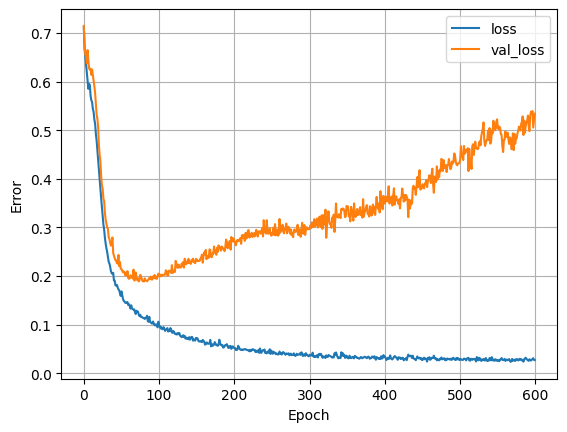

In [13]:
plot_loss(history)

## Let's evaluate the model on the test dataset

In [14]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(np.array(x_exp_data_test), np.array(y_exp_data_test), batch_size=1)
print("test loss, test acc:", results)

Evaluate on test data
100/100 [==============================] - 0s 383us/step - loss: 0.4094 - accuracy: 0.9600
test loss, test acc: [0.4093925952911377, 0.9599999785423279]
